In [1]:
import os
import tensorflow as tf


TRAIN_DIR = os.getenv('HOME') + '/aiffel/chest_xray/data/train'
TEST_DIR = os.getenv('HOME') + '/aiffel/chest_xray/data/test'
VAL_DIR = os.getenv('HOME') + '/aiffel/chest_xray/data/val'

train_filename_list = tf.io.gfile.glob(TRAIN_DIR + '/*/*.jpeg')
train_filename_list.extend(tf.io.gfile.glob(VAL_DIR + '/*/*.jpeg'))
test_filename_list = tf.io.gfile.glob(TEST_DIR + '/*/*.jpeg')

print("train:", len(train_filename_list))
print("test:", len(test_filename_list))

train: 5232
test: 624


In [2]:
NUMS_NORMAL = len([filename for filename in train_filename_list if "NORMAL" in filename])
NUMS_PNEUMONIA = len([filename for filename in train_filename_list if "PNEUMONIA" in filename])

print('Normal:', NUMS_NORMAL)
print('Pneumonia:', NUMS_PNEUMONIA)

Normal: 1349
Pneumonia: 3883


In [3]:
import math
import random


LEN_TRAIN = math.floor(len(train_filename_list) * 0.8)
LEN_VAL = len(train_filename_list) - LEN_TRAIN
LEN_TEST = len(test_filename_list)

random.shuffle(train_filename_list)
val_filename_list = train_filename_list[LEN_TRAIN:]
train_filename_list = train_filename_list[:LEN_TRAIN]

In [4]:
train_filename_ds = tf.data.Dataset.from_tensor_slices(train_filename_list)
val_filename_ds = tf.data.Dataset.from_tensor_slices(val_filename_list)
test_filename_ds = tf.data.Dataset.from_tensor_slices(test_filename_list)

print('train:', tf.data.experimental.cardinality(train_filename_ds))
print('val:', tf.data.experimental.cardinality(val_filename_ds))
print('test:', tf.data.experimental.cardinality(test_filename_ds))

train: tf.Tensor(4185, shape=(), dtype=int64)
val: tf.Tensor(1047, shape=(), dtype=int64)
test: tf.Tensor(624, shape=(), dtype=int64)


In [5]:
def get_label(filename_tensor):
    label = tf.strings.split(filename_tensor, os.path.sep)[-2]
    return label == "PNEUMONIA"

In [6]:
IMAGE_SIZE = (180, 180)

def get_img(filename_tensor):
    img = tf.io.read_file(filename_tensor)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

In [7]:
def load_data_from_filename(filename_tensor):
    label = get_label(filename_tensor)
    img = get_img(filename_tensor)
    return img, label

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_filename_ds.map(load_data_from_filename,
                                      num_parallel_calls=AUTOTUNE)
val_dataset = val_filename_ds.map(load_data_from_filename,
                                      num_parallel_calls=AUTOTUNE)
test_dataset = test_filename_ds.map(load_data_from_filename,
                                      num_parallel_calls=AUTOTUNE)

# 데이터 전처리

In [9]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    return img, label

In [10]:
BATCH_SIZE = 16

def prepare_for_training(dataset, shuffle_buffer_size=1000):
    dataset = dataset.map(augment, num_parallel_calls=2)
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [11]:
train_dataset = prepare_for_training(train_dataset)
val_dataset = prepare_for_training(val_dataset)
test_dataset = prepare_for_training(test_dataset)

In [12]:
import matplotlib.pyplot as plt

def show_batch(img_batch, label_batch):
    plt.figure(figsize=(10, 10))
    
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n + 1)
        plt.imshow(img_batch[n])
        
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

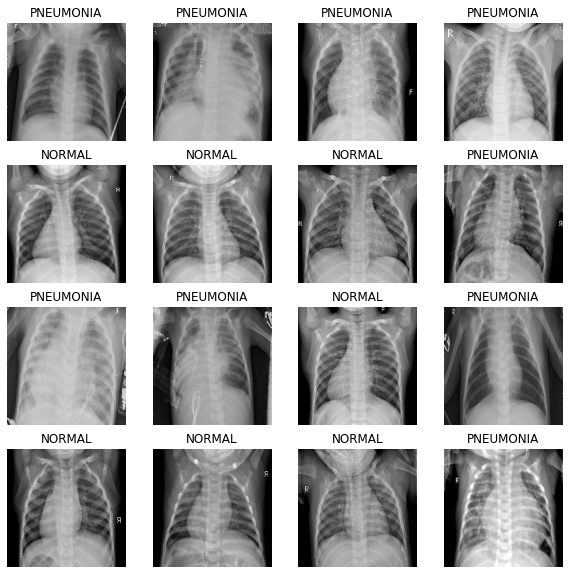

In [13]:
img_batch, label_batch = next(iter(train_dataset))
show_batch(img_batch.numpy(), label_batch.numpy())

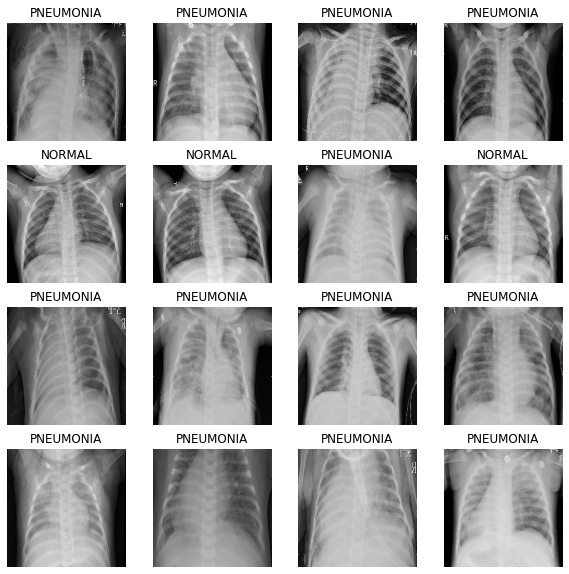

In [14]:
img_batch, label_batch = next(iter(val_dataset))
show_batch(img_batch.numpy(), label_batch.numpy())

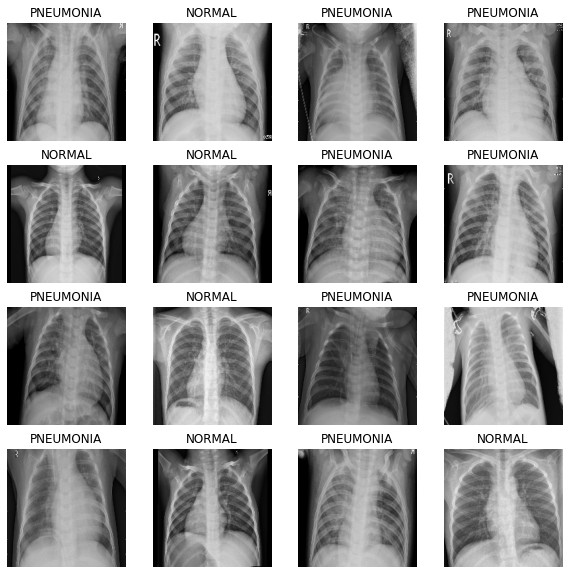

In [15]:
img_batch, label_batch = next(iter(test_dataset))
show_batch(img_batch.numpy(), label_batch.numpy())

# 모델 선언

In [16]:
L2_WEIGHT_DECAY = 1e-4

def gen_l2_regularizer(use):
    return tf.keras.regularizers.l2(L2_WEIGHT_DECAY) if use else None

In [17]:
def conv_block(x, n_filters, use_regularizer=True, dropout=0.1):
    out = tf.keras.layers.SeparableConv2D(
        n_filters, 
        3, 
        padding="same",
        
        kernel_initializer='he_normal',
        kernel_regularizer=gen_l2_regularizer(use_regularizer)
    )(x)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.ReLU()(out)
    
    out = tf.keras.layers.SeparableConv2D(
        n_filters, 
        3,
        kernel_initializer='he_normal',
        kernel_regularizer=gen_l2_regularizer(use_regularizer)
    )(out)
    out = tf.keras.layers.BatchNormalization()(out)
    if dropout:
        out = tf.keras.layers.Dropout(dropout)(out)
        
    res = tf.keras.layers.SeparableConv2D(
        n_filters, 
        3,
        kernel_initializer='he_normal',
        kernel_regularizer=gen_l2_regularizer(use_regularizer)
    )(x)
    out = tf.keras.layers.ReLU()(out + res)
    
    return out
    
def identity_block(x, n_filters, use_regularizer=True, dropout=0.1):
    out = tf.keras.layers.SeparableConv2D(
        n_filters, 
        3, 
        padding="same",
        kernel_initializer='he_normal',
        kernel_regularizer=gen_l2_regularizer(use_regularizer)
    )(x)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.ReLU()(out)
    
    out = tf.keras.layers.SeparableConv2D(
        n_filters, 
        3, 
        padding="same",
        kernel_initializer='he_normal',
        kernel_regularizer=gen_l2_regularizer(use_regularizer)
    )(out)
    out = tf.keras.layers.BatchNormalization()(out)
    if dropout:
        out = tf.keras.layers.Dropout(dropout)(out)
        
    res = tf.keras.layers.SeparableConv2D(
        n_filters, 
        3, 
        padding="same",
        kernel_initializer='he_normal',
        kernel_regularizer=gen_l2_regularizer(use_regularizer)
    )(x)
    
    out = tf.keras.layers.ReLU()(out + res)
    
    return out

In [18]:
def resnet18(input_shape=(224, 224, 3), batch_size=None, use_regularizer=True, dropout=0.1):
    x = tf.keras.layers.Input(shape=input_shape, batch_size=None)
    
    out = tf.keras.layers.SeparableConv2D(
        64, 
        7,
        strides=(2, 2),
        kernel_initializer='he_normal',
        kernel_regularizer=gen_l2_regularizer(use_regularizer),
    )(x)
    out = tf.keras.layers.MaxPooling2D((3,3), strides=(2, 2))(out)
    
    out = identity_block(out, 32, use_regularizer, dropout)
    out = conv_block(out, 32, use_regularizer, dropout)
    
    out = identity_block(out, 64, use_regularizer, dropout)
    out = conv_block(out, 64, use_regularizer, dropout)
    
    out = identity_block(out, 128, use_regularizer, dropout)
    out = conv_block(out, 128, use_regularizer, dropout)
    
    out = identity_block(out, 256, use_regularizer, dropout)
    out = conv_block(out, 256, use_regularizer, dropout)
    
    out = tf.keras.layers.AveragePooling2D((7,7))(out)
    out = tf.keras.layers.Flatten()(out)
    out = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(out)
    
    return tf.keras.Model(x, out)

In [19]:
model = resnet18(input_shape=(180, 180, 3), batch_size=BATCH_SIZE, dropout=None)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 87, 87, 64)   403         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 43, 43, 64)   0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 43, 43, 32)   2656        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [20]:
weight_normal = (1 / NUMS_NORMAL) * LEN_TRAIN / 2.0
weight_pneumonia = (1 / NUMS_PNEUMONIA) * LEN_TRAIN / 2.0

class_weight = {0: weight_normal, 1: weight_pneumonia}
print(class_weight)

{0: 1.5511489992587102, 1: 0.5388874581509143}


In [21]:
EPOCHS = 30

compile_setting = {
    'optimizer': tf.keras.optimizers.RMSprop(learning_rate=0.0005),
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy', 
                tf.keras.metrics.Precision(name='precision'), 
                tf.keras.metrics.Recall(name='recall')]
}

fit_setting = {
    'steps_per_epoch': LEN_TRAIN // BATCH_SIZE,
    'epochs': EPOCHS,
    'callbacks': [tf.keras.callbacks.EarlyStopping(patience=5)],
    'validation_data': val_dataset,
    'validation_steps': LEN_VAL // BATCH_SIZE,
    'class_weight': class_weight
}

In [22]:
model.compile(**compile_setting)

with tf.device('/GPU:0'):
    history = model.fit(train_dataset, **fit_setting)

Epoch 1/30
261/261 [==============================] - 73s 216ms/step - loss: 0.1733 - accuracy: 0.9207 - precision: 0.9684 - recall: 0.9228 - val_loss: 0.5619 - val_accuracy: 0.7558 - val_precision: 0.7558 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 57s 217ms/step - loss: 0.1221 - accuracy: 0.9452 - precision: 0.9776 - recall: 0.9475 - val_loss: 2.9513 - val_accuracy: 0.7558 - val_precision: 0.7558 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 57s 218ms/step - loss: 0.0998 - accuracy: 0.9576 - precision: 0.9827 - recall: 0.9595 - val_loss: 0.1564 - val_accuracy: 0.9346 - val_precision: 0.9283 - val_recall: 0.9898
Epoch 4/30
261/261 [==============================] - 57s 218ms/step - loss: 0.0793 - accuracy: 0.9650 - precision: 0.9877 - recall: 0.9647 - val_loss: 3.0247 - val_accuracy: 0.7702 - val_precision: 0.7671 - val_recall: 0.9987
Epoch 5/30
261/261 [==============================] - 56s 216ms/step - loss: 0.0808 - accura

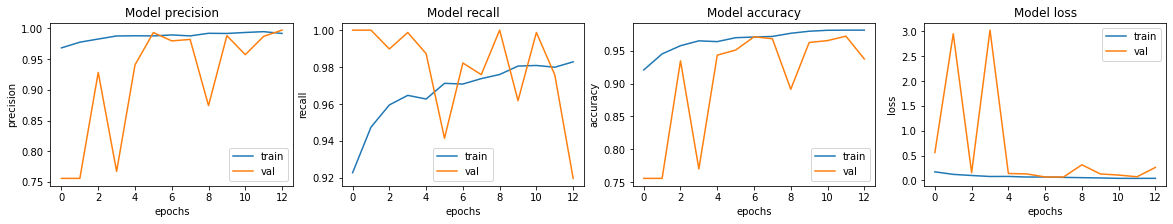

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_dataset, steps=LEN_TEST // BATCH_SIZE)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 13s 131ms/step - loss: 0.9858 - accuracy: 0.8189 - precision: 0.7941 - recall: 0.9590
Loss: 0.9857807755470276,
Accuracy: 0.8189102411270142,
Precision: 0.7940552234649658,
Recall: 0.9589743614196777


In [25]:
def test_model(use_regularizer=True, dropout=0.1):
    model = resnet18(input_shape=(180, 180, 3), batch_size=BATCH_SIZE, use_regularizer=True, dropout=0.1)
    
    model.compile(**compile_setting)
    with tf.device('/GPU:0'):
        history = model.fit(train_dataset, **fit_setting)
        
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    plt.show()
    
    loss, accuracy, precision, recall = model.evaluate(test_dataset, steps=LEN_TEST // BATCH_SIZE)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
test_model()